In [2]:
import numpy as np
import matplotlib.pyplot as mpl

Assigning values to the parameters:

In [3]:

# K+ concentrations :
Ki = 0.15 # M, inside
Krest = 0.0035 # Resting Ko. M., outside

R = 8.3 # J mol-1 K-1
F = 95600 # C mol-1
T = 273 + 32 # Recording temperature
GKmax = 1e-5 #1/10MOhm. A Guess. Needs a big prefactor?
Cm = 3e-10 # F
Gl = 1e-7 # Leak conductance of 1/10MOhm.
El = -0.05 # V


# For now work in concentrations rather than quantities.
#Vint = 6e-15 # litres. Volume of the internode peri-axonal space.
dt = 1e-6 # s, 10 milliseconds of delta t
APefflux = 0.001 # M change in Ko with AP.
APtimes = np.arange(0,0.2,0.01) # Roughly 20 APs at 10ms intervals.
times = np.arange(0,2,1e-6)
Km = 0.002 # M the affinity of the ATPase Na+/K+ for K+
Vmax = 0.02 # M s-1


## 1) Modelisation of K+ extracellular concentration

### Function to mimick the influx of K+ in the myelin during succesion of APs in the axon :
- It's gonna add APefflux to the concentration if we are at a time t where there is a new AP (known by APtimes)
- It's gonna remove the amount of K+ that is imported inside the cell by the ATPase NA+/K+

I have change t, t+dt into t-dt, t


In [4]:
def dK(t,Ko,dt=dt):
    # Tedious calculation to add K efflux at correct time steps.
    d = 0
    if sum(APtimes < (t-dt)) < sum(APtimes < t): #meaning that the t+dt is reaching the timing of a new AP
        d += APefflux # addition of K+ efflux from the neuronal activity
    d -= dt*0.02*(Ko - Krest)/(Km + (Ko - Krest)) #we also decrease d with the ATPase activity that takes K+ ions inside the cell ( Michaelis-Menten model)
    return d


### Function to generate the evolution of extracellular [K+] upon time:

In [5]:
def Kintegrate(times, Krest=Krest):
    K = np.full(len(times), Krest) #initialisation at the resting concentration of K+
    for i in np.arange(1, len(times)):
        K[i] = K[i-1] + dK(times[i], K[i-1]) #at each time points, we add to the concentration the change dK, that is calculated based on the concentration and the time
    return K

**Model 1 : Only K+ AP efflux and ATPase Na+/K+**

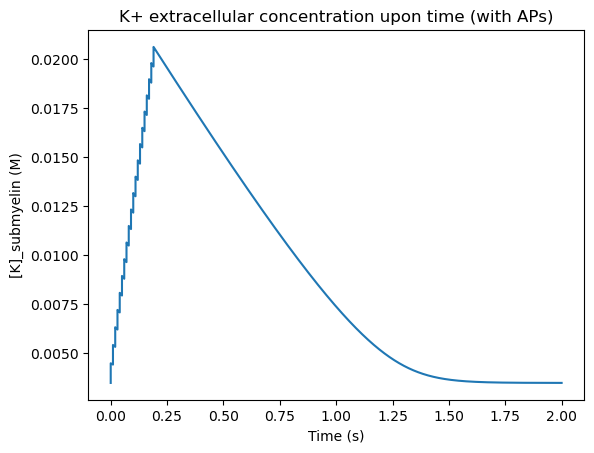

In [6]:
K = Kintegrate(times)
mpl.plot(times, K)
mpl.xlabel("Time (s)")
mpl.ylabel("[K]_submyelin (M)")
mpl.title("K+ extracellular concentration upon time (with APs)")
mpl.show()

In [42]:
K[50000]


np.float64(0.007953503487853083)

## 2) Modelisation of the voltage of the myelin

If we consider there is no additional K+ current with a specific channel involved, what would be the voltage ?
We could use GHK equation, but simplify it by only considering K+ ions ?

In [7]:
Vm = np.full(len(times), 0)
for i in range (0,len(times)):
    Vm[i] = (R*T/F*np.log(K[i]/Ki))*1000


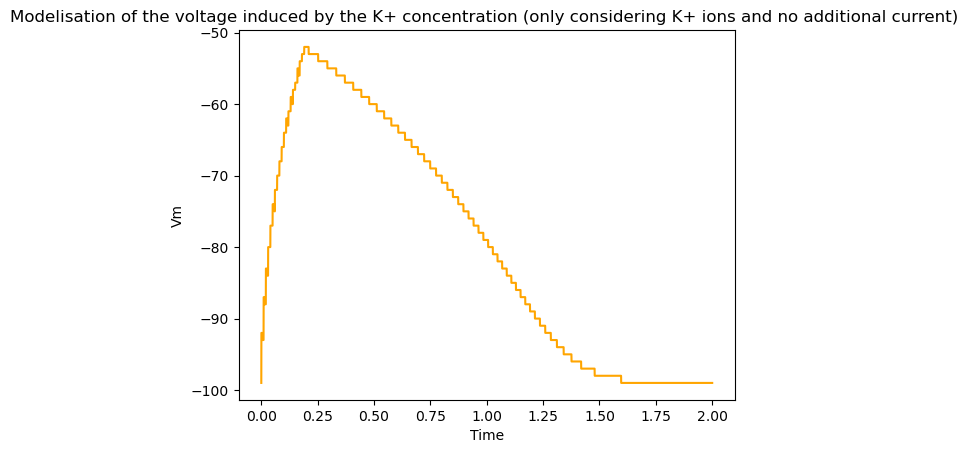

In [32]:
fig,ax=mpl.subplots()
mpl.plot(times, Vm,color='orange')
ax.set_xlabel("Time")
ax.set_ylabel("Vm")
mpl.title('Modelisation of the voltage induced by the K+ concentration (only considering K+ ions and no additional current) ')
mpl.show()

Here, we have a problem because the resting potential is the Eeq of the K+ ion, whereas in the myelin the resting potential is El=-50mV (and not -100mV)
TO DO : try with using also the other ions ?

### Function to calculate current through inward rectifier.
Using the formulation of https://link.springer.com/article/10.1007/BF01870103
D(elta)V = V - EK
gK = A/[1 + exp((DV + 15mV)/7mV)]*np.sqrt(Ko)
We can probably just assume the steady-state conductance and neglect any transient regimes.

**TO DO: use activities?**

In [11]:
# V volts, Ko molar.
def I_KIR(V, Ko):
    EK = R*T/F*np.log(Ko/Ki) #calculating the Equilibrium potential for K+ with Nernst Law
    DV = V - EK*1000 #driving force with conversion in mV
    return DV*GKmax/(1 + np.exp((DV+15)/7))*np.sqrt(Ko)

Plotting the IV curve :

In [ ]:
V = np.arange(-120,40,2)
def I_curve( V,Krest):
    I = np.zeros(len(V))
    for i in np.arange(0, len(V)):
        I[i]= I_KIR(V[i], Krest)
    return I


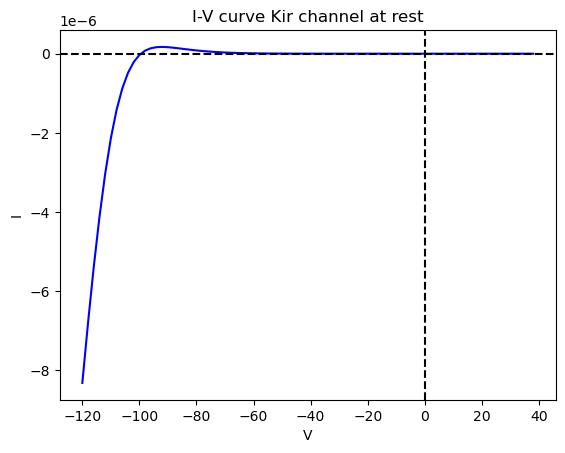

In [48]:
fig,ax=mpl.subplots()
Icurve = I_curve( V,Krest)
mpl.plot(V, Icurve,'blue',label='Ko~0.0035M (Krest)')
ax.set_xlabel("V")
ax.set_ylabel("I")
mpl.title("I-V curve Kir channel at rest")
mpl.axhline(y=0, color='k',linestyle='--')
mpl.axvline(x=0, color='k',linestyle='--')
mpl.show()

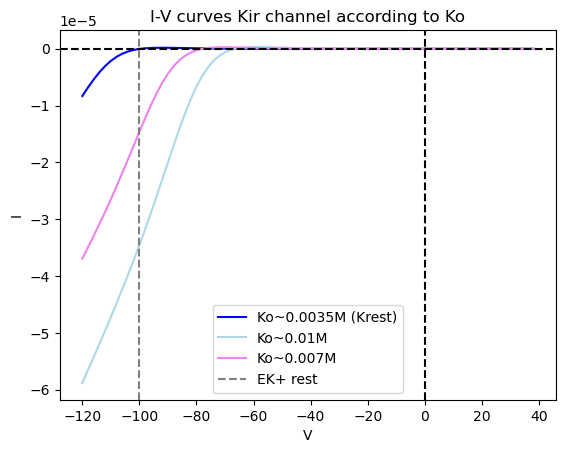

In [50]:

fig,ax=mpl.subplots()
Icurve = I_curve( V,Krest)
mpl.plot(V, Icurve,'blue',label='Ko~0.0035M (Krest)')
Icurve2=I_curve( V,K[100000])
mpl.plot(V, Icurve2,'lightblue',label='Ko~0.01M')
Icurve3=I_curve( V,K[50000])
mpl.plot(V, Icurve3,'violet',label='Ko~0.007M')
ax.set_xlabel("V")
ax.set_ylabel("I")
mpl.axhline(y=0, color='k',linestyle='--')
mpl.axvline(x=0, color='k',linestyle='--')
mpl.axvline(x=-100,color='grey',linestyle='--',label='EK+ rest')
mpl.title("I-V curves Kir channel according to Ko")
ax.legend()
mpl.show()

--> The Eeq of the channel is going to change according to the outside K+ concentration. When it is  high, there is more inward K+ current at the same voltage of the membrane.

### I upon Ko at the resting potential (El=-50mV)
I am looking at the plot I upon  Ko, at a given V (El). It might don't be pertinent since the V is changing with KO changing.

In [13]:
I_KO = I_KIR(np.full(len(K),-50),K) #here i try V as the El

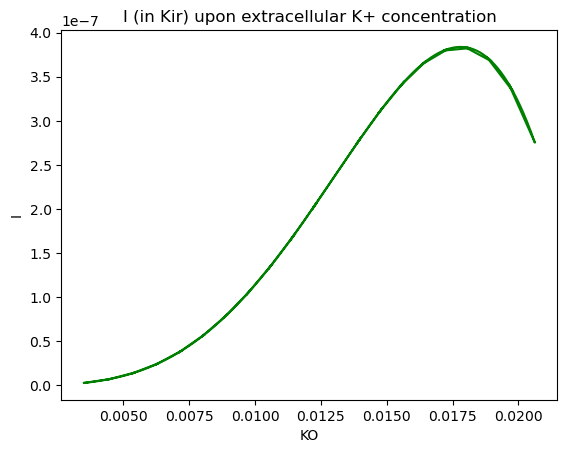

In [22]:
fig,ax=mpl.subplots()
mpl.plot(K, I_KO, color='green')
ax.set_xlabel("KO")
ax.set_ylabel("I")
mpl.title('I (in Kir) upon extracellular K+ concentration')
mpl.show()

### Integrating the current through the Kir into change in voltage

In [26]:
def Vintegrate(times,Ko,El):
    V = np.full(len(times), El*1000) #Initialisation so that the V[0] is El (with conversion in mV)
    for i in np.arange(0, len(times)-1):
        V[i+1]= dt/Cm*I_KIR(V[i],Ko[i])+V[i] #Using the formula I=CmdV/dt=Cm(V(t+dt)-V(t))/dt
    return V

In [28]:
V = Vintegrate(times,K,El)
V

array([-50.        , -49.99999029, -49.99996563, ...,  -4.41567117,
        -4.41567114,  -4.41567112], shape=(2000000,))

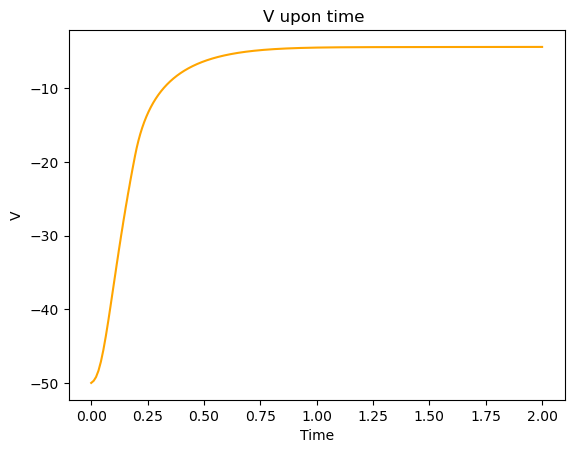

In [30]:
fig,ax=mpl.subplots()
mpl.plot(times, V,color='orange')
ax.set_xlabel("Time")
ax.set_ylabel("V")
mpl.title("V upon time ")
mpl.show()

-> DOesnt seem correct : we observe a depolarisation that stabilise over time, instead of coming back to the resting potential of the myelin
Problably the I=CdV/dt is not good here (i am comparing a capacitive current with a conductive current).